In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import numpy as np
from PIL import Image
import random

In [2]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
def train_validate(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=10):
    
    model = model.to(device)
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(num_epochs):
        
        model.train()
        running_train_loss = 0.0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.append(predicted)
                all_labels.append(labels)

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        all_predictions = torch.cat(all_predictions).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        val_precision = precision_score(all_labels, all_predictions, average='macro')
        val_recall = recall_score(all_labels, all_predictions, average='macro')
        val_f1 = f1_score(all_labels, all_predictions, average='macro')

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

   
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accs": val_accs,
        "val_precisions": val_precisions,
        "val_recalls": val_recalls,
        "val_f1s": val_f1s,
    }

In [4]:
num_epochs=20

In [5]:
def plot_val_metrics(metrics):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    epochs = range(1, len(metrics['train_losses']) + 1)

    ax1.plot(epochs, metrics['val_losses'], color='red')
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(epochs, metrics['val_accs'], color='blue')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
valset   = DataClass(split='val', transform=transforms.ToTensor(), download=True)
testset  = DataClass(split='test', transform=transforms.ToTensor(), download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
val_dataloader   = data.DataLoader(dataset=valset, batch_size=128, shuffle=False)
test_dataloader  = data.DataLoader(dataset=testset, batch_size=128, shuffle=False)

def extract_unique_labels(dataset):
    unique_labels = set()
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = int(label[0])
        unique_labels.add(label)
    return sorted(list(unique_labels))

classes = extract_unique_labels(trainset)

label_counts = {}

for data, target in train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

print(f"Train size: {len(trainset)}")
print(f"Validation size: {len(valset)}")
print(f"Test size: {len(testset)}")

Label 1: 2181 images
Label 3: 2026 images
Label 6: 2330 images
Label 4: 849 images
Label 7: 1643 images
Label 2: 1085 images
Label 0: 852 images
Label 5: 993 images
Train size: 11959
Validation size: 1712
Test size: 3421


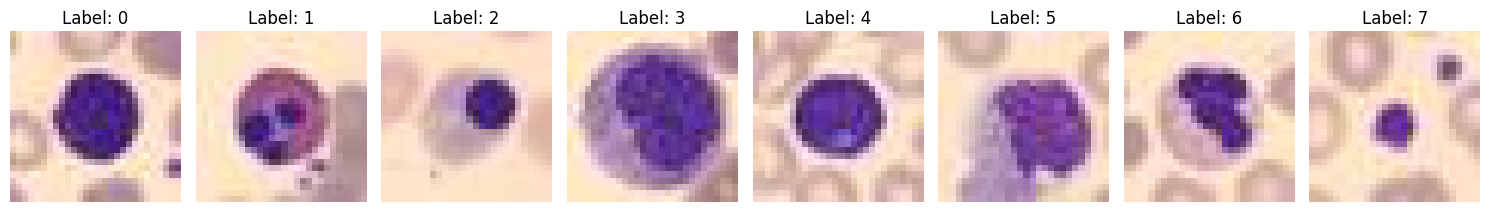

In [7]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = label.item()

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/20 | Train Loss: 1.3143 | Val Loss: 0.8600 | Val Acc: 70.68% | Val Precision: 0.7158 | Val Recall: 0.6482 | Val F1: 0.6322
Epoch 2/20 | Train Loss: 0.8340 | Val Loss: 0.7370 | Val Acc: 74.59% | Val Precision: 0.7483 | Val Recall: 0.7099 | Val F1: 0.7132
Epoch 3/20 | Train Loss: 0.7149 | Val Loss: 0.6706 | Val Acc: 75.47% | Val Precision: 0.7548 | Val Recall: 0.6992 | Val F1: 0.7111
Epoch 4/20 | Train Loss: 0.5902 | Val Loss: 0.5308 | Val Acc: 81.02% | Val Precision: 0.7887 | Val Recall: 0.7828 | Val F1: 0.7782
Epoch 5/20 | Train Loss: 0.5203 | Val Loss: 0.4793 | Val Acc: 82.13% | Val Precision: 0.8165 | Val Recall: 0.7761 | Val F1: 0.7750
Epoch 6/20 | Train Loss: 0.4500 | Val Loss: 0.4099 | Val Acc: 86.16% | Val Precision: 0.8497 | Val Recall: 0.8402 | Val F1: 0.8388
Epoch 7/20 | Train Loss: 0.4236 | Val Loss: 0.3989 | Val Acc: 85.75% | Val Precision: 0.8557 | Val Recall: 0.8310 | Val F1: 0.8364
Epoch 8/20 | Train Loss: 0.3805 | Val Loss: 0.3590 | Val Acc: 87.44% | Val Precisio

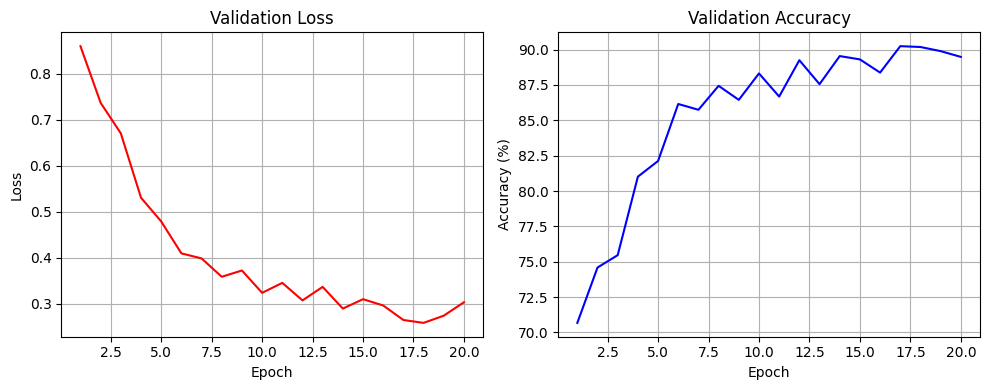

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

original_metrics = train_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(original_metrics)

In [10]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  
        self.labels = np.load(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2: 
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

In [11]:
generated_dataset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

total_size = len(generated_dataset)
generated_train_size = int(0.7 * total_size)
generated_val_size = int(0.1 * total_size)
generated_test_size = total_size - generated_train_size - generated_val_size

generated_trainset, generated_valset, generated_testset = random_split(
    generated_dataset,
    [generated_train_size, generated_val_size, generated_test_size],
    generator=torch.Generator().manual_seed(42)
)

generated_train_dataloader = DataLoader(generated_trainset, batch_size=128, shuffle=True)
generated_val_dataloader   = DataLoader(generated_valset, batch_size=128, shuffle=False)
generated_test_dataloader  = DataLoader(generated_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(generated_trainset)}")
print(f"Validation size: {len(generated_valset)}")
print(f"Test size: {len(generated_testset)}")

Train size: 5600
Validation size: 800
Test size: 1600


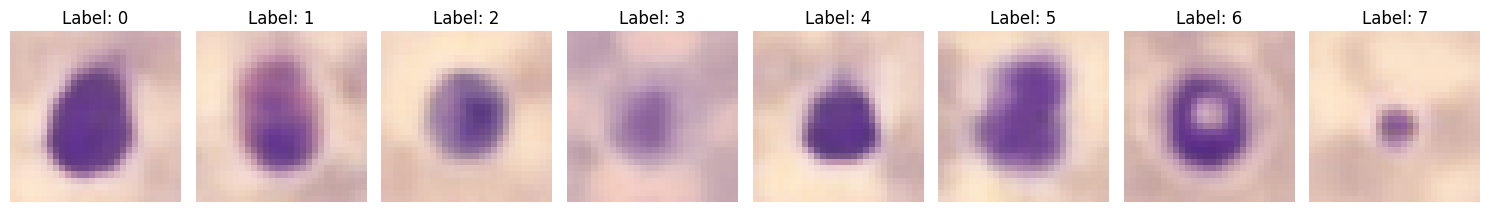

In [12]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(generated_trainset)):
    image, label = generated_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

Epoch 1/20 | Train Loss: 1.6678 | Val Loss: 0.8394 | Val Acc: 77.25% | Val Precision: 0.8093 | Val Recall: 0.7641 | Val F1: 0.7624
Epoch 2/20 | Train Loss: 0.6213 | Val Loss: 0.5421 | Val Acc: 80.00% | Val Precision: 0.8536 | Val Recall: 0.7960 | Val F1: 0.7670
Epoch 3/20 | Train Loss: 0.4481 | Val Loss: 0.3793 | Val Acc: 86.38% | Val Precision: 0.8828 | Val Recall: 0.8633 | Val F1: 0.8625
Epoch 4/20 | Train Loss: 0.4107 | Val Loss: 0.3320 | Val Acc: 88.75% | Val Precision: 0.8952 | Val Recall: 0.8914 | Val F1: 0.8842
Epoch 5/20 | Train Loss: 0.3396 | Val Loss: 0.3004 | Val Acc: 89.25% | Val Precision: 0.9094 | Val Recall: 0.8908 | Val F1: 0.8946
Epoch 6/20 | Train Loss: 0.3253 | Val Loss: 0.2602 | Val Acc: 91.38% | Val Precision: 0.9186 | Val Recall: 0.9141 | Val F1: 0.9137
Epoch 7/20 | Train Loss: 0.2834 | Val Loss: 0.2995 | Val Acc: 88.75% | Val Precision: 0.9000 | Val Recall: 0.8909 | Val F1: 0.8803
Epoch 8/20 | Train Loss: 0.2751 | Val Loss: 0.2488 | Val Acc: 91.12% | Val Precisio

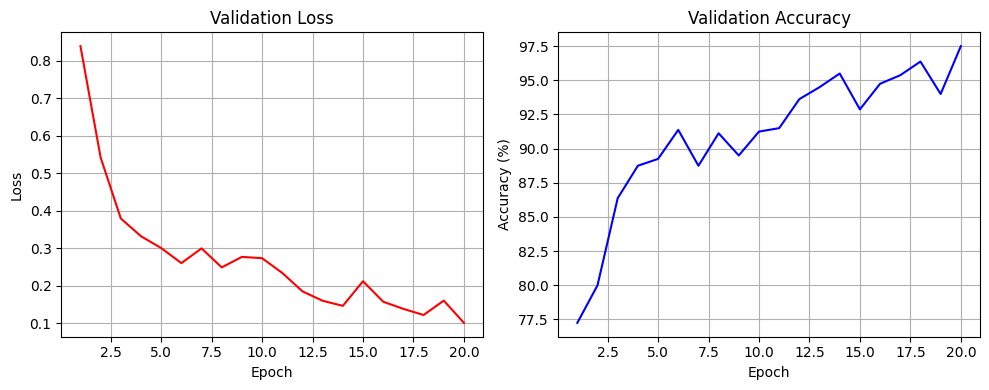

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

generated_metrics = train_validate(
    model=model,
    train_dataloader=generated_train_dataloader,
    val_dataloader=generated_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(generated_metrics)

In [15]:
# bloodMNIST ima label kao numpy array
class FixedBloodMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label

Epoch 1/20 | Train Loss: 1.2961 | Val Loss: 0.8603 | Val Acc: 71.26% | Val Precision: 0.7048 | Val Recall: 0.6934 | Val F1: 0.6958
Epoch 2/20 | Train Loss: 0.8187 | Val Loss: 0.7442 | Val Acc: 72.97% | Val Precision: 0.7666 | Val Recall: 0.7051 | Val F1: 0.7096
Epoch 3/20 | Train Loss: 0.6663 | Val Loss: 0.6104 | Val Acc: 78.30% | Val Precision: 0.7953 | Val Recall: 0.7445 | Val F1: 0.7416
Epoch 4/20 | Train Loss: 0.5375 | Val Loss: 0.4864 | Val Acc: 82.88% | Val Precision: 0.8158 | Val Recall: 0.8138 | Val F1: 0.8074
Epoch 5/20 | Train Loss: 0.4852 | Val Loss: 0.4246 | Val Acc: 85.39% | Val Precision: 0.8508 | Val Recall: 0.8370 | Val F1: 0.8396
Epoch 6/20 | Train Loss: 0.4201 | Val Loss: 0.4565 | Val Acc: 82.92% | Val Precision: 0.8234 | Val Recall: 0.8284 | Val F1: 0.8118
Epoch 7/20 | Train Loss: 0.3814 | Val Loss: 0.3889 | Val Acc: 87.14% | Val Precision: 0.8908 | Val Recall: 0.8530 | Val F1: 0.8632
Epoch 8/20 | Train Loss: 0.3541 | Val Loss: 0.3559 | Val Acc: 87.66% | Val Precisio

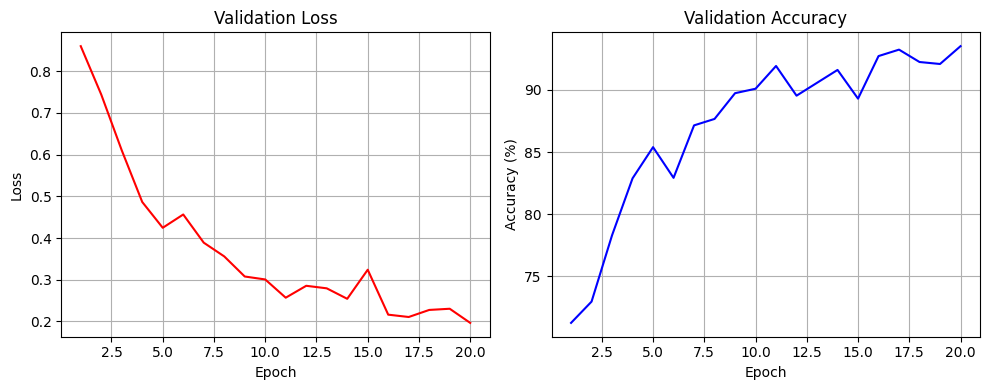

In [16]:
combined_trainset = ConcatDataset([FixedBloodMNIST(trainset), generated_trainset])
combined_valset = ConcatDataset([FixedBloodMNIST(valset), generated_valset])
combined_testset = ConcatDataset([FixedBloodMNIST(testset), generated_testset])

combined_train_loader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
combined_val_dataloader = DataLoader(combined_valset, batch_size=128, shuffle=False)
combined_test_dataloader = DataLoader(combined_testset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

combined_metrics = train_validate(
    model=model,
    train_dataloader=combined_train_loader,
    val_dataloader=combined_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(combined_metrics)

In [17]:
def balance_dataset(original_dataset, generated_dataset, target_per_class, classes):

    def indices_by_label(dataset, label):
        return [i for i, (_, lbl) in enumerate(dataset) if int(lbl) == label]

    balanced_indices = []
    combined_dataset = ConcatDataset([original_dataset, generated_dataset])
    offset = len(original_dataset)

    for label in classes:
        original_indices = indices_by_label(original_dataset, label)
        generated_indices = indices_by_label(generated_dataset, label)

        random.shuffle(original_indices)
        random.shuffle(generated_indices)

        total_available = len(original_indices) + len(generated_indices)

        if total_available <= target_per_class:
            chosen_orig = original_indices
            chosen_gen_shifted = [i + offset for i in generated_indices]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)
        else:
            needed_from_gen = target_per_class - len(original_indices)
            needed_from_gen = max(0, needed_from_gen)
            chosen_orig = original_indices[:target_per_class]
            chosen_gen_shifted = [i + offset for i in generated_indices[:needed_from_gen]]
            balanced_indices.extend(chosen_orig + chosen_gen_shifted)

    return Subset(combined_dataset, balanced_indices)


In [18]:
target_per_class = 2500

balanced_dataset = balance_dataset(FixedBloodMNIST(ConcatDataset([trainset, valset, testset])), generated_dataset, target_per_class, classes)

balanced_size = len(balanced_dataset)
balanced_train_size = int(0.7 * balanced_size)
balanced_val_size = int(0.1 * balanced_size)
balanced_test_size = balanced_size - balanced_train_size - balanced_val_size

balanced_trainset, balanced_valset, balanced_testset = random_split(
    balanced_dataset,
    [balanced_train_size, balanced_val_size, balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

balanced_train_dataloader = DataLoader(balanced_trainset, batch_size=128, shuffle=True)
balanced_val_dataloader   = DataLoader(balanced_valset, batch_size=128, shuffle=False)
balanced_test_dataloader  = DataLoader(balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(balanced_trainset)}")
print(f"Validation size: {len(balanced_valset)}")
print(f"Test size: {len(balanced_testset)}")

Train size: 13546
Validation size: 1935
Test size: 3871


In [19]:
label_counts = {}

for data, target in balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')


Label 4: 1554 images
Label 5: 1704 images
Label 0: 1544 images
Label 1: 1707 images
Label 7: 1784 images
Label 2: 1774 images
Label 6: 1730 images
Label 3: 1749 images


Epoch 1/20 | Train Loss: 1.3815 | Val Loss: 1.0321 | Val Acc: 63.05% | Val Precision: 0.6974 | Val Recall: 0.6344 | Val F1: 0.6242
Epoch 2/20 | Train Loss: 0.8754 | Val Loss: 0.7766 | Val Acc: 72.61% | Val Precision: 0.7213 | Val Recall: 0.7239 | Val F1: 0.7076
Epoch 3/20 | Train Loss: 0.7338 | Val Loss: 0.6641 | Val Acc: 77.98% | Val Precision: 0.7746 | Val Recall: 0.7753 | Val F1: 0.7720
Epoch 4/20 | Train Loss: 0.6414 | Val Loss: 0.5913 | Val Acc: 78.66% | Val Precision: 0.7893 | Val Recall: 0.7862 | Val F1: 0.7760
Epoch 5/20 | Train Loss: 0.5835 | Val Loss: 0.5455 | Val Acc: 81.50% | Val Precision: 0.8196 | Val Recall: 0.8152 | Val F1: 0.8098
Epoch 6/20 | Train Loss: 0.5187 | Val Loss: 0.4842 | Val Acc: 83.36% | Val Precision: 0.8347 | Val Recall: 0.8301 | Val F1: 0.8291
Epoch 7/20 | Train Loss: 0.4719 | Val Loss: 0.4544 | Val Acc: 84.96% | Val Precision: 0.8541 | Val Recall: 0.8473 | Val F1: 0.8492
Epoch 8/20 | Train Loss: 0.4318 | Val Loss: 0.4242 | Val Acc: 84.86% | Val Precisio

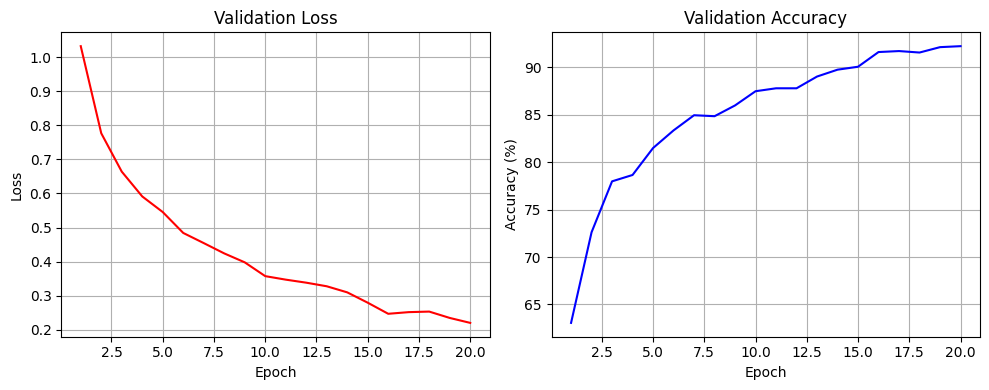

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

balanced_metrics = train_validate(
    model=model,
    train_dataloader=balanced_train_dataloader,
    val_dataloader=balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(balanced_metrics)

In [21]:
class BlurredDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label


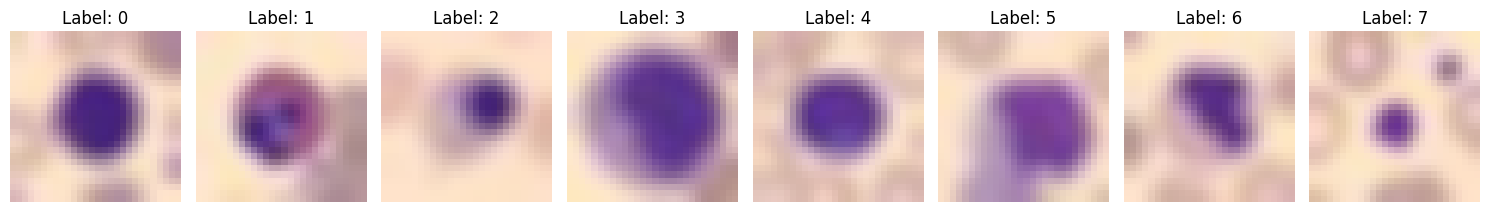

In [22]:
blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=5, sigma=(1, 4.0)),
    transforms.ToTensor()
])

blurred_trainset = BlurredDataset(trainset, blur_transform)
blurred_valset = BlurredDataset(valset, blur_transform)
blurred_testset = BlurredDataset(testset, blur_transform)


plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(blurred_trainset)):
    image, label = blurred_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [23]:
target_per_class = 2500

blurred_balanced_dataset = balance_dataset(ConcatDataset([blurred_trainset, blurred_valset, blurred_testset]), generated_dataset, target_per_class, classes)

blurred_balanced_size = len(blurred_balanced_dataset)
blurred_balanced_train_size = int(0.7 * blurred_balanced_size)
blurred_balanced_val_size = int(0.1 * blurred_balanced_size)
blurred_balanced_test_size = blurred_balanced_size - blurred_balanced_train_size - blurred_balanced_val_size

blurred_balanced_trainset, blurred_balanced_valset, blurred_balanced_testset = random_split(
    blurred_balanced_dataset,
    [blurred_balanced_train_size, blurred_balanced_val_size, blurred_balanced_test_size],
    generator=torch.Generator().manual_seed(42)
)

blurred_balanced_train_dataloader = DataLoader(blurred_balanced_trainset, batch_size=128, shuffle=True)
blurred_balanced_val_dataloader   = DataLoader(blurred_balanced_valset, batch_size=128, shuffle=False)
blurred_balanced_test_dataloader  = DataLoader(blurred_balanced_testset, batch_size=128, shuffle=False)

print(f"Train size: {len(blurred_balanced_trainset)}")
print(f"Validation size: {len(blurred_balanced_valset)}")
print(f"Test size: {len(blurred_balanced_testset)}")

label_counts = {}

for data, target in blurred_balanced_train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Train size: 13546
Validation size: 1935
Test size: 3871
Label 4: 1554 images
Label 2: 1774 images
Label 0: 1544 images
Label 7: 1784 images
Label 3: 1749 images
Label 6: 1730 images
Label 5: 1704 images
Label 1: 1707 images


Epoch 1/20 | Train Loss: 1.4201 | Val Loss: 1.1204 | Val Acc: 56.54% | Val Precision: 0.6377 | Val Recall: 0.5771 | Val F1: 0.5346
Epoch 2/20 | Train Loss: 0.9932 | Val Loss: 0.9664 | Val Acc: 63.36% | Val Precision: 0.6821 | Val Recall: 0.6405 | Val F1: 0.6374
Epoch 3/20 | Train Loss: 0.8893 | Val Loss: 0.8398 | Val Acc: 70.70% | Val Precision: 0.7153 | Val Recall: 0.7035 | Val F1: 0.6956
Epoch 4/20 | Train Loss: 0.7869 | Val Loss: 0.7116 | Val Acc: 73.95% | Val Precision: 0.7436 | Val Recall: 0.7373 | Val F1: 0.7312
Epoch 5/20 | Train Loss: 0.6848 | Val Loss: 0.7020 | Val Acc: 73.75% | Val Precision: 0.7639 | Val Recall: 0.7347 | Val F1: 0.7151
Epoch 6/20 | Train Loss: 0.6086 | Val Loss: 0.5993 | Val Acc: 77.31% | Val Precision: 0.7849 | Val Recall: 0.7682 | Val F1: 0.7609
Epoch 7/20 | Train Loss: 0.5604 | Val Loss: 0.5241 | Val Acc: 80.88% | Val Precision: 0.8239 | Val Recall: 0.8029 | Val F1: 0.8067
Epoch 8/20 | Train Loss: 0.5034 | Val Loss: 0.4997 | Val Acc: 80.52% | Val Precisio

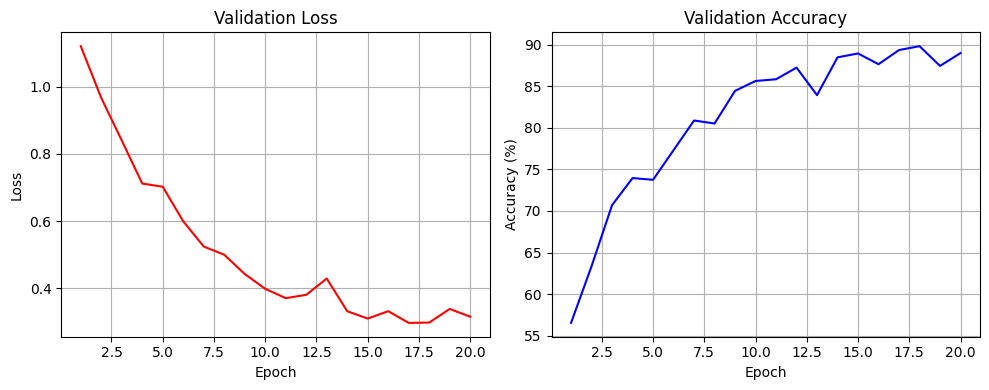

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

blurred_balanced_metrics = train_validate(
    model=model,
    train_dataloader=blurred_balanced_train_dataloader,
    val_dataloader=blurred_balanced_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

plot_val_metrics(blurred_balanced_metrics)

In [25]:
def test_model(model, test_dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_predictions.append(preds)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Test Accuracy: {accuracy:.4f} | "
            f"Test Precision: {precision:.4f} | "
            f"Test Recall: {recall:.4f} | "
            f"Test F1: {f1:.4f}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [26]:
print("Original dataset")
original_test_metrics = test_model(model=model, test_dataloader=test_dataloader, device=device)

print("Generated dataset")
generated_test_metrics = test_model(model=model, test_dataloader=generated_test_dataloader, device=device)

print("Combined dataset")
combined_test_metrics = test_model(model=model, test_dataloader=combined_test_dataloader, device=device)

print("Balanced dataset")
balanced_test_metrics = test_model(model=model, test_dataloader=balanced_test_dataloader, device=device)

print("Blurred balanced dataset")
blurred_balanced_test_metrics = test_model(model=model, test_dataloader=blurred_balanced_test_dataloader, device=device)

Original dataset
Test Accuracy: 0.8188 | Test Precision: 0.8184 | Test Recall: 0.8071 | Test F1: 0.7886
Generated dataset
Test Accuracy: 0.8456 | Test Precision: 0.8418 | Test Recall: 0.8500 | Test F1: 0.7974
Combined dataset
Test Accuracy: 0.8273 | Test Precision: 0.8213 | Test Recall: 0.8325 | Test F1: 0.8146
Balanced dataset
Test Accuracy: 0.8546 | Test Precision: 0.8659 | Test Recall: 0.8561 | Test F1: 0.8525
Blurred balanced dataset
Test Accuracy: 0.8814 | Test Precision: 0.8910 | Test Recall: 0.8790 | Test F1: 0.8821
